<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = ['datetime'])
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [3]:
taxi = taxi.sort_index()
print(taxi.index.is_monotonic)
taxi.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.isna().sum()

num_orders    0
dtype: int64

In [5]:
taxi = taxi.resample('1H').sum() # ресемплирование по одному часу
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [6]:
print('Статистика:')
print(taxi['num_orders'].describe())

Статистика:
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


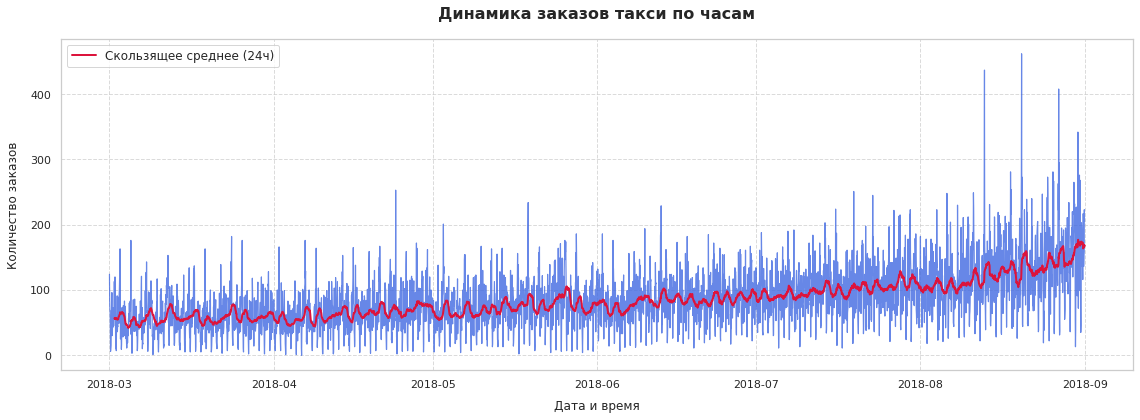

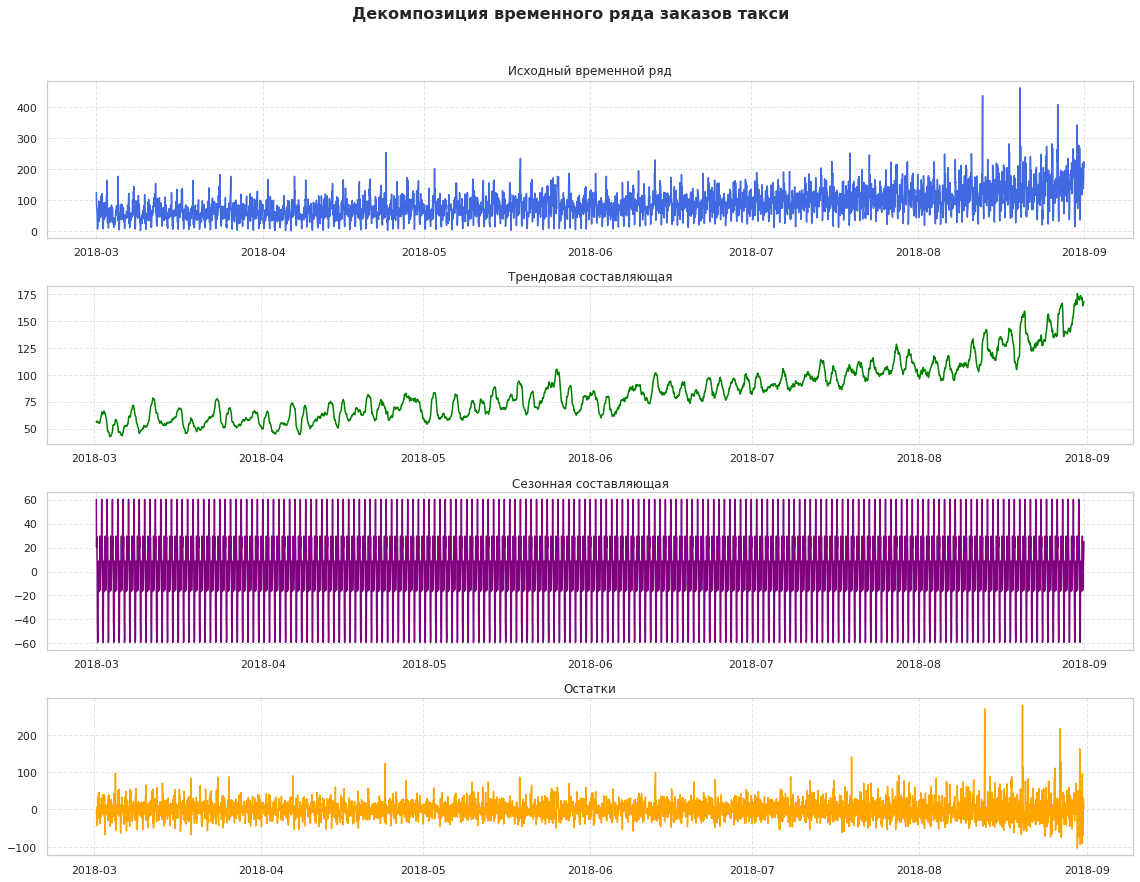

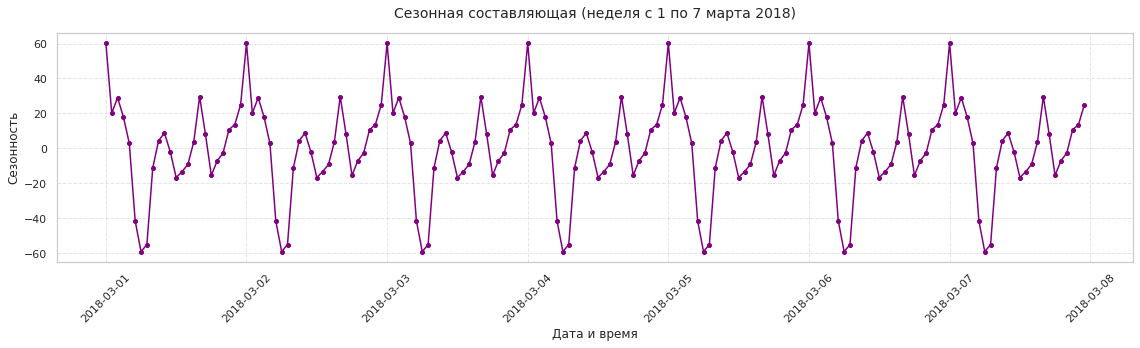

In [7]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(16, 6))
plt.plot(taxi.index, taxi['num_orders'], 
         color='royalblue', 
         linewidth=1.2,
         alpha=0.8)

# Добавляем скользящее среднее для лучшего восприятия тренда
rolling_mean = taxi['num_orders'].rolling(window=24).mean()
plt.plot(taxi.index, rolling_mean, 
         color='crimson', 
         linewidth=2, 
         label='Скользящее среднее (24ч)')

plt.title('Динамика заказов такси по часам', 
          fontsize=16, 
          pad=20, 
          fontweight='bold')
plt.xlabel('Дата и время', fontsize=12, labelpad=10)
plt.ylabel('Количество заказов', fontsize=12, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Декомпозиция временного ряда
decomposition = seasonal_decompose(taxi['num_orders'], period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

# Оригинальный ряд
ax1.plot(decomposition.observed, color='royalblue')
ax1.set_title('Исходный временной ряд', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Тренд
ax2.plot(decomposition.trend, color='green')
ax2.set_title('Трендовая составляющая', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Сезонность
ax3.plot(decomposition.seasonal, color='purple')
ax3.set_title('Сезонная составляющая', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.5)

# Остатки
ax4.plot(decomposition.resid, color='orange')
ax4.set_title('Остатки', fontsize=12)
ax4.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Декомпозиция временного ряда заказов такси', 
             fontsize=16, 
             fontweight='bold',
             y=1.02)
plt.tight_layout()
plt.show()

# Детальный просмотр сезонности за неделю
plt.figure(figsize=(16, 5))
week_seasonal = decomposition.seasonal['2018-03-01':'2018-03-07']
plt.plot(week_seasonal, 
         color='purple', 
         marker='o', 
         markersize=4,
         linewidth=1.5)

plt.title('Сезонная составляющая (неделя с 1 по 7 марта 2018)', 
          fontsize=14,
          pad=15)
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Сезонность', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Чтобы выявить недельную сезонность в данных, нам нужно выполнить ресемплинг данных по дням и затем провести повторную декомпозицию временного ряда.

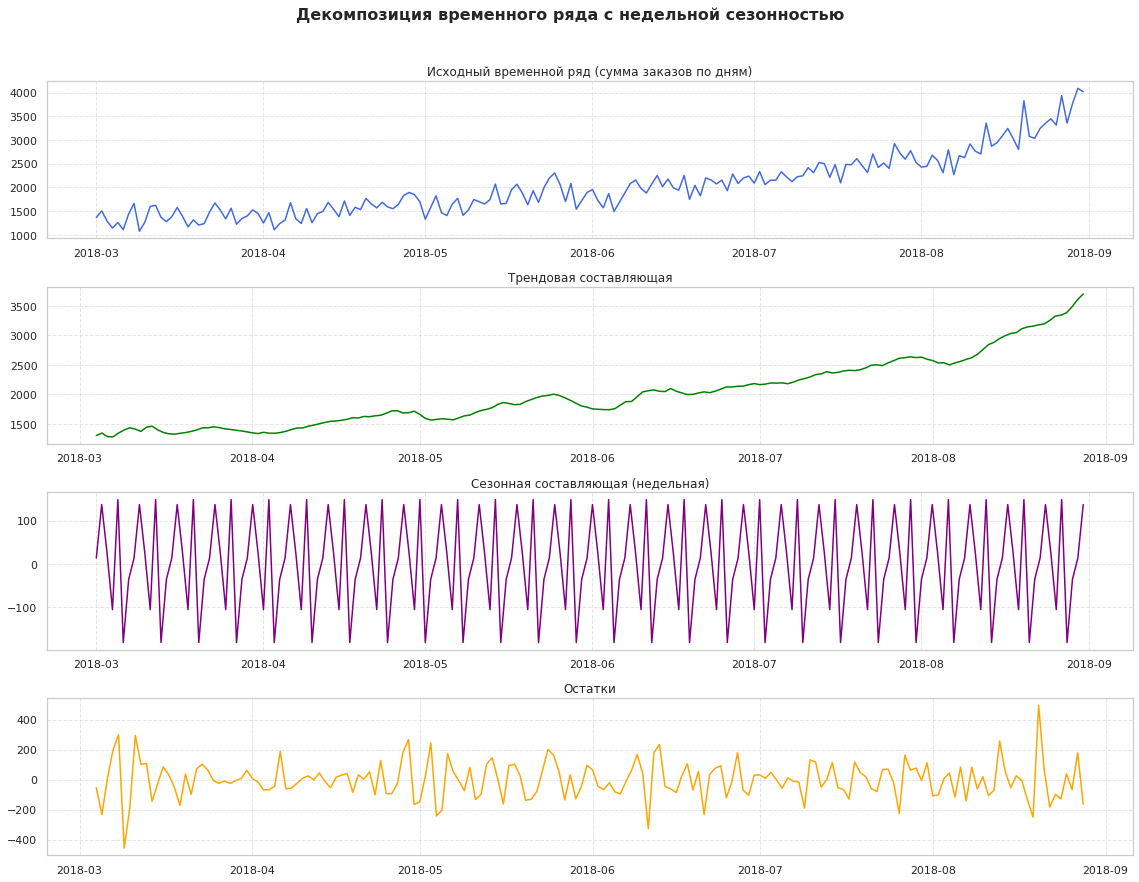

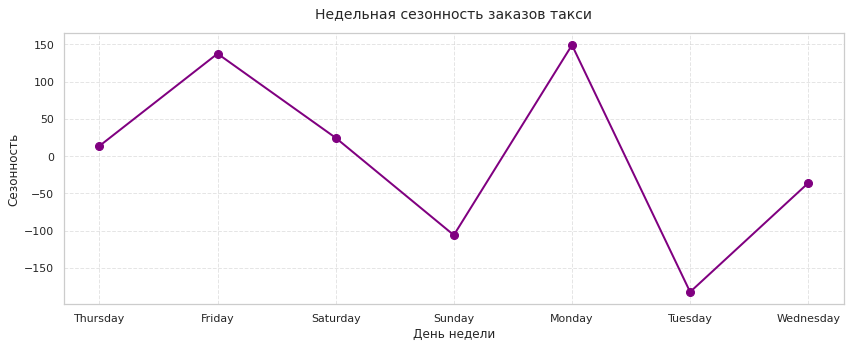

In [8]:
# Ресемплинг данных по дням
daily_taxi = taxi['num_orders'].resample('D').sum()

# Декомпозиция с недельной сезонностью (period=7)
decomposition_weekly = seasonal_decompose(daily_taxi, period=7)

# Визуализация декомпозиции с недельной сезонностью
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

# Оригинальный ряд
ax1.plot(decomposition_weekly.observed, color='royalblue')
ax1.set_title('Исходный временной ряд (сумма заказов по дням)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Тренд
ax2.plot(decomposition_weekly.trend, color='green')
ax2.set_title('Трендовая составляющая', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Сезонность (недельная)
ax3.plot(decomposition_weekly.seasonal, color='purple')
ax3.set_title('Сезонная составляющая (недельная)', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.5)

# Остатки
ax4.plot(decomposition_weekly.resid, color='orange')
ax4.set_title('Остатки', fontsize=12)
ax4.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Декомпозиция временного ряда с недельной сезонностью', 
             fontsize=16, 
             fontweight='bold',
             y=1.02)
plt.tight_layout()
plt.show()

# Визуализация недельной сезонности (один период)
plt.figure(figsize=(12, 5))
one_period = decomposition_weekly.seasonal[:7]
plt.plot(one_period.index.day_name(), one_period.values, 
         color='purple', 
         marker='o', 
         markersize=8,
         linewidth=2)

plt.title('Недельная сезонность заказов такси', 
          fontsize=14,
          pad=15)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Сезонность', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
1. Суточная сезонность:

    - Пик заказов: полночь (возможно, связано с закрытием баров/ресторанов, окончанием мероприятий)

    - Минимум спроса: 6-7 утра (когда большинство людей спит)
    

2. Тренд роста (март-сентябрь):

    Возможные причины:

    - Теплый сезон (больше туристов, активность на улицах)

    - Летние фестивали и мероприятия

    - Увеличение светового дня
    

3. Недельная сезонность:

    - Пик спроса на такси приходится на понедельник и пятницу
    
    - Минимум спроса во вторник


## Обучение

In [9]:
def create_features(df, max_lag=168, rolling_mean_size=168):
    df = df.copy()
    
    # Лаговые признаки
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    # Скользящие средние
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Временные признаки
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    return df

In [10]:
data_features = create_features(taxi)
data_features = data_features.dropna()

# Разделение на признаки и целевую переменную
X = data_features.drop('num_orders', axis=1)
y = data_features['num_orders']

In [11]:
# Вычисляем размер тестовой выборки (10%)
test_size = int(len(X) * 0.1)

# Разделяем данные БЕЗ перемешивания, сохраняя временной порядок
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Проверяем размеры выборок
print(f"Тренировочная выборка: {len(X_train)} samples")
print(f"Тестовая выборка: {len(X_test)} samples")

# Проверяем временные границы 
if isinstance(X.index, pd.DatetimeIndex):
    print("\nВременные границы:")
    print(f"Тренировочная: {X_train.index.min()} — {X_train.index.max()}")
    print(f"Тестовая: {X_test.index.min()} — {X_test.index.max()}")

Тренировочная выборка: 3824 samples
Тестовая выборка: 424 samples

Временные границы:
Тренировочная: 2018-03-08 00:00:00 — 2018-08-14 07:00:00
Тестовая: 2018-08-14 08:00:00 — 2018-08-31 23:00:00


In [12]:
X_train.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10',
       ...
       'lag_162', 'lag_163', 'lag_164', 'lag_165', 'lag_166', 'lag_167',
       'lag_168', 'rolling_mean', 'hour', 'dayofweek'],
      dtype='object', length=171)

In [13]:
# Определяем признаки
numeric_features = ['rolling_mean'] + [f'lag_{i+1}' for i in range(168)]
categorical_features = ['hour', 'dayofweek']

In [14]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [15]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('regressor', LinearRegression())  
])

In [16]:
# Создаем TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
# Оценка модели через кросс-валидацию для временных рядов
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
print(f'Linear Regression CV RMSE: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})')

Linear Regression CV RMSE: 23.2404 (±2.5470)


In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  
        ('cat', OrdinalEncoder(), categorical_features)  
    ],
    remainder='drop'
)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5]
}

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print("\nЛучшие параметры:", grid_search.best_params_)
print(f"Лучший RMSE (CV): {abs(grid_search.best_score_):.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   1.1s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   2.1s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   2.9s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   3.8s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   4.8s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   2.1s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   3.9s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   5.8s
[CV] END regressor__max_depth=5, regress

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
        ('num', 'passthrough', numeric_features)  
    ])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        enable_categorical=False,
        tree_method='hist'
    ))
])

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
print(f'Baseline XGBoost CV RMSE: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})')

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=tscv,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("\nЛучшие параметры:", grid_search.best_params_)
print(f"Лучший RMSE (CV): {grid_search.best_score_:.4f}")

Baseline XGBoost CV RMSE: 24.9173 (±4.0390)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 50}
Лучший RMSE (CV): 24.6070


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'
)

cat_indices = [X_train.columns.get_loc(col) for col in categorical_features]

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        random_state=42,
        verbosity=-1,
        force_row_wise=True
    ))
])


params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__max_depth': [5, 7],
    'regressor__num_leaves': [31, 63],
    'regressor__categorical_feature': [cat_indices]
}

grid = GridSearchCV(
    estimator=lgb_pipeline,
    param_grid=params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)


grid.fit(X_train, y_train)
print("Лучшие параметры:", grid.best_params_)
print(f"Лучший RMSE (CV): {abs(grid.best_score_):.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   5.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   1.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   2.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=  42.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=  51.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   6.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   7.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time= 1.5min


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=  10.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   8.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.8s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=  16.9s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   6.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   5.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   6.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   8.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   9.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   9.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=  15.8s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=   8.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=   8.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=  10.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=  16.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   1.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.4s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   2.4s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   1.9s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=100, regressor__num_leaves=63; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   3.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=31; total time=   6.4s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   2.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   4.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=5, regressor__n_estimators=200, regressor__num_leaves=63; total time=   6.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   1.8s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   4.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   6.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=31; total time=   5.9s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   2.5s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   2.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   5.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   9.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=100, regressor__num_leaves=63; total time=   6.8s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.1s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.0s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   7.6s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=   9.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=31; total time=  32.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=   3.4s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=   5.7s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=  15.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=  13.3s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[CV] END regressor__categorical_feature=[169, 170], regressor__learning_rate=0.2, regressor__max_depth=7, regressor__n_estimators=200, regressor__num_leaves=63; total time=  26.8s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Лучшие параметры: {'regressor__categorical_feature': [169, 170], 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__num_leaves': 63}
Лучший RMSE (CV): 23.6710


Лучшая модель оказалась RandomForestRegressor. Лучший RMSE (CV): 23.0239

## Тестирование

In [24]:
rf_pipeline.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_test_pred = rf_pipeline.predict(X_test)

# Расчет метрик на тестовой выборке
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nОценка на тестовой выборке:')
print(f'RMSE {test_rmse:.4f}')


Оценка на тестовой выборке:
RMSE 39.0258


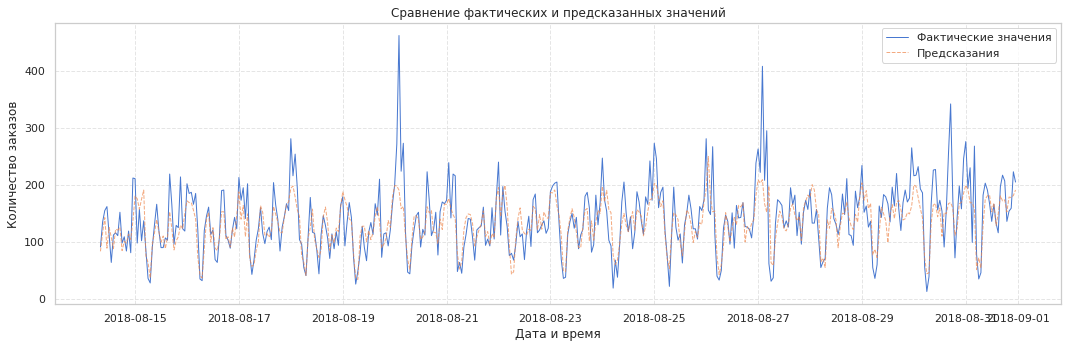

In [25]:
plt.figure(figsize=(15, 5))

# Сортируем данные по индексу (если это временной ряд)
if isinstance(y_test.index, pd.DatetimeIndex):
    y_test_sorted = y_test.sort_index()
    y_test_pred_sorted = pd.Series(y_test_pred, index=y_test.index).sort_index()
else:
    y_test_sorted = y_test
    y_test_pred_sorted = y_test_pred

# Визуализация
plt.plot(y_test_sorted.index, y_test_sorted, label='Фактические значения', linewidth=1)
plt.plot(y_test_sorted.index, y_test_pred_sorted, 
         label='Предсказания', 
         linestyle='--', 
         alpha=0.7,
         linewidth=1)

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Дата и время' if isinstance(y_test.index, pd.DatetimeIndex) else 'Наблюдения')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Выводы

1. После анализа данных выявлены суточные и недельные сезонные закономерности в количестве заказов такси.

2. Были протестированы несколько моделей:

    - Линейная регрессия показала RMSE (CV): 23.2404 (±2.5470)

    - Случайный лес показал RMSE (CV): 23.0239

    - XGBoost показал RMSE (CV): 24.6070

    - LightGBM показал RMSE (CV): 23.6710


3. Лучшая модель оказалась Линейная регрессия (по скорости и результату RMSE) на тестовой выборке показала RMSE 39.0258, что удовлетворяет требованию заказчика (RMSE ≤ 48).

4. Модель может быть использована для прогнозирования спроса на такси в следующем часу, что позволит компании оптимально распределять водителей в периоды пиковой нагрузки.